# =======================================================
# PART 3: NEXT STEPS
# =======================================================

In [ ]:
#Taking what we have learned from analyzing the kaggle dataset, we decided that we needed more information to try to  
# predict profit. We are applying what we learned from our Kaggle analysis to our the numbers dataset. 

In [1]:
#Ali and Kendra Final Project 

#importing pandas, csv, 
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
#To create testing and training dfs and labels 
from sklearn.model_selection import train_test_split 
# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB
# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score
#confusion matrix 
from sklearn.metrics import confusion_matrix, classification_report

#for pre-processing to fit all numeric data on the standard scale 
from sklearn.preprocessing import StandardScaler
#for applying PCA function on training and testing sets 
from sklearn.decomposition import PCA
#logistic regression 
from sklearn.linear_model import LogisticRegression
#SVMs 
from sklearn.svm import SVC
#For association rule mining 
from apyori import apriori
#This will allow us to silence the warnings
import warnings 
warnings.simplefilter("ignore")
#For the confusion matrix 
import seaborn as sns

In [2]:
#Functions that we are going to use in our file: 

#Creating a function that will change a column data type to category 
def cat_fun(df, column): 
    df[column] = df[column].astype("category") 
    return(df[column])

#Creating a function that will remove anything in our df and replace it with nothing 
def remove(df, column, object_to_remove): 
    df[column] = df[column].str.replace(object_to_remove, "")
    return(df[column])

#Creating a function that will discretize our columns based on quartiles 
def quartile_discretize(df, column, categories): 
    df[column] = pd.qcut(df[column], 4, labels = categories)
    return(df[column])

#Creating a function that will merge our dfs with a left join
def left_merge_2_conditions(df1, df2, column1, column2):
    df = pd.merge(df1, df2, how = "left", on=[column1, column2])
    return(df)

#Creating a function that groups by, counts, creates a new column from the index, drops the index and changes the column names
def groupby_count(df, groupby_column, count_column): 
    new_df = pd.DataFrame(df.groupby(groupby_column)[count_column].count())
    new_df.columns = ["count"]
    new_df[groupby_column] = new_df.index.get_level_values(0)
    new_df.reset_index(drop = True, inplace = True)
    return(new_df)

#Creating a function that groups by, counts, creates a new column from the index, drops the index and changes the column names
def groupby_2_count(df, groupby_column1, groupby_column2, count_column): 
    new_df = pd.DataFrame(df.groupby([groupby_column1, groupby_column2 ])[count_column].count())
    new_df.columns = ["count"]
    new_df[groupby_column1] = new_df.index.get_level_values(0)
    new_df[groupby_column2] = new_df.index.get_level_values(1)
    new_df.reset_index(drop = True, inplace = True)
    return(new_df)

# Going to use matplotlib for plotting... 
# To create a plot we followed the following formula: 
# df.plot(x-axis, y-axis, kind = type of plot, color = [(we specified colors to use here)], legend = False (we did not 
# want a legend displayed), title = "Title") then we added a ylabel with plt.ylabel("Type label here") and an x label 
# with plt.xlabel("type label here"). Finally, we wanted to change the direction of the xtick names from a 90 degree angle 
# to no angle with plt.xticks(rotation = rotation angle desired)
def bar_graph_count(df, x_column, y_column, title):
    g = df.plot(x_column, y_column, kind = "bar", legend = False, title = title)
    g = plt.ylabel(y_column)
    g = plt.xlabel(x_column)
    return(g)


#This will calculate the exponential moving average of the columns we want
#exponential moving averages give more weight to the most recent data and less weight to older data 
def exp_moving_avg(d, column_to_be_meaned):
    d["exp_moving_avg"] = d[column_to_be_meaned].ewm(span=40,adjust=False).mean()
    exp_moving_avg = list(d["exp_moving_avg"])
    #Adding a 0 to the first entry to exp_moving_avg
    exp_moving_avg = [0] + exp_moving_avg
    #Removing the last entry in the list 
    exp_moving_avg.pop()
    #Creating a column named exp_moving_avg with the results 
    d["exp_moving_avg"] = exp_moving_avg
    return(exp_moving_avg)

#This will calculate the cumulative moving average
def cumulative_moving_avg(d): 
    d["moving_avg"] = d.expanding(min_periods = 1).mean()
    moving_avg = list(d["moving_avg"])
    #Adding a 0 to the first entry to moving avg
    cumulative_moving_avg = [0] + moving_avg
    #Removing the last entry in the list 
    cumulative_moving_avg.pop()
    return(cumulative_moving_avg)

#This will get the list of all of the entries in the column that we are interested in for calculating the averages
def getting_list_of_entries(df, column_interested_in, column_to_be_meaned): 
    avg_people = pd.DataFrame(df.groupby([column_interested_in, "released"])[column_to_be_meaned].mean())
    avg_column_scores = pd.DataFrame()
    column_interested = list(df[column_interested_in].unique())
    return([avg_people, column_interested])

#This will make a df for our moving averages that we are calculating 
def making_df(people_df, column_interested_in, released, person, cumulative_avg, exp_avg): 
    df_2 = pd.DataFrame({column_interested_in: person, "released": released, "cumulative_mean": cumulative_avg, "exp_mean": exp_avg})
    return(df_2)

#This includes the functions above, and will calculate the exponential and cumulative moving averages for which ever 
#column we specify and return a df will the column interested in, released, cumulative_mean, exp_mean
def calculating_moving_avg(df, column_interested_in, column_to_be_meaned, ty):
    people_df = pd.DataFrame()
    people = getting_list_of_entries(df, column_interested_in, column_to_be_meaned)
    cumulative_avg = []
    avg_people = people[0]
    avg_people
    for person in people[1]: 
        d = avg_people.groupby(column_interested_in).get_group(person)
        cumulative_avg = cumulative_moving_avg(d)
        exp_avg = exp_moving_avg(d, column_to_be_meaned)
        d.reset_index(inplace = True)
        released = d["released"]
        df = pd.DataFrame({column_interested_in: person, "released": released, ty+"_cumulative_mean_"+column_interested_in : cumulative_avg, ty+"_exp_mean_"+column_interested_in: exp_avg})
        people_df = people_df.append(df)
    return(people_df)

#Confusion Matrix Graph Function 
def confusion_matrix_graph (cm, accuracy_label, type_of_df): 
    g = plt.figure(figsize=(2,2))
    g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', cbar = False);
    g = plt.ylabel('Actual');
    g = plt.xlabel('Predicted');
    g = all_sample_title = type_of_df +' Accuracy Score: {0}'.format(round(accuracy_label, 4))
    g = plt.title(all_sample_title, size = 12);
    return(g)

In [3]:
#reading in the V2_TN_reports.csv that we scraped 
movies = pd.read_csv("V2_TN_reports_dates.csv", encoding = "ISO-8859-1")

In [4]:
movies.head()

,Unnamed: 0,CreativeType,DomesticBoxOffice,Genre,Infl.Adj.Dom.BoxOffice,InternationalBoxOffice,MaximumTheaters,OpeningWeekendRevenue,OpeningWeekendTheaters,ProductionBudget,ProductionMethod,Released,ReleasedWorldwide,ReleasedWorldwide_2,Released_2,Source,TheatricalDistributor,TheatricalEngagements,Title,WorldwideBoxOffice
0,0,Fantasy,"$317,871,467",Adventure,"$510,437,208","$657,176,139","3,672","$90,294,621","3,672","$125,000,000",Animation/Live Action,"Nov 16, 2001","Nov 15, 2001",2001,2001,Based on Fiction Book/Short Story,Warner Bros.,"36,120",Harry Potter and the SorcererÃ¢ÂÂs Stone,"$975,047,606"
1,1,Fantasy,"$315,544,750",Adventure,"$502,999,394","$571,666,235","3,381","$47,211,490","3,359","$109,000,000",Animation/Live Action,"Dec 19, 2001","Dec 19, 2001",2001,2001,Based on Fiction Book/Short Story,New Line,"39,234",The Lord of the Rings: The Fellowshipâ¦,"$887,210,985"
2,2,Kids Fiction,"$289,423,425",Adventure,"$449,635,428","$270,334,294","3,649","$62,577,067","3,237","$115,000,000",Digital Animation,"Nov 2, 2001","Nov 2, 2001",2001,2001,Original Screenplay,Walt Disney,"45,411","Monsters, Inc.","$559,757,719"
3,3,Kids Fiction,"$267,655,011",Adventure,"$430,801,615","$224,157,783","3,715","$42,347,760","3,587","$50,000,000",Digital Animation,"May 18, 2001","May 18, 2001",2001,2001,Based on Fiction Book/Short Story,Dreamworks SKG,"40,234",Shrek,"$491,812,794"
4,4,Kids Fiction,"$260,044,825",Adventure,"$438,980,791","$85,096,578","3,256","$55,820,330","3,127","$123,000,000",Live Action,"Nov 17, 2000","Nov 17, 2000",2000,2000,Based on Fiction Book/Short Story,Universal,"27,579",How the Grinch Stole Christmas,"$345,141,403"


In [5]:
#We are dropping the first column named Unnamed:0 
movies.drop("Unnamed: 0", axis = 1, inplace = True)

In [6]:
movies.shape

(1987, 19)

In [7]:
#We have 1987 movies and 19 columns in our current df 
#We are going to drop any rows if they have nas or missing values for budget
movies.dropna(inplace = True)

In [8]:
len(movies)

1971

In [9]:
#We had 16 movies with missing values... 
#Now we are going to drop any movies with 0s in budget 
movies = movies[movies["ProductionBudget"] != "$0"]

In [10]:
len(movies)
#We did not have any movies with a 0 budget 

1971

In [11]:
#We are going to drop any movies with a DomesticBoxOffice of 0 
movies = movies[movies["DomesticBoxOffice"] != "$0"]

In [12]:
len(movies)

1952

In [13]:
#We had 19 movies with missing domestic box office info 

#We are going to change column names to something a little more user friendly. First, we will look at the column names 
movies.columns

Index(['CreativeType', 'DomesticBoxOffice', 'Genre', 'Infl.Adj.Dom.BoxOffice',
       'InternationalBoxOffice', 'MaximumTheaters', 'OpeningWeekendRevenue',
       'OpeningWeekendTheaters', 'ProductionBudget', 'ProductionMethod',
       'Released', 'ReleasedWorldwide', 'ReleasedWorldwide_2', 'Released_2',
       'Source', 'TheatricalDistributor', 'TheatricalEngagements', 'Title',
       'WorldwideBoxOffice'],
      dtype='object')

In [14]:
column_names = ["creative_type", "domestic_box_office", "genre", "inflated_adj_dom_box_office", "int_box_office", "max_theaters", 
                "open_wkend_rev", "open_wkend_theaters", "budget", "production_method", "released", "released_ww", "year",
                "year_ww", "source", "distributor", "engagements", "title", "world_wide_box_office"]
movies.columns = column_names

In [15]:
movies.head()

,creative_type,domestic_box_office,genre,inflated_adj_dom_box_office,int_box_office,max_theaters,open_wkend_rev,open_wkend_theaters,budget,production_method,released,released_ww,year,year_ww,source,distributor,engagements,title,world_wide_box_office
0,Fantasy,"$317,871,467",Adventure,"$510,437,208","$657,176,139","3,672","$90,294,621","3,672","$125,000,000",Animation/Live Action,"Nov 16, 2001","Nov 15, 2001",2001,2001,Based on Fiction Book/Short Story,Warner Bros.,"36,120",Harry Potter and the SorcererÃ¢ÂÂs Stone,"$975,047,606"
1,Fantasy,"$315,544,750",Adventure,"$502,999,394","$571,666,235","3,381","$47,211,490","3,359","$109,000,000",Animation/Live Action,"Dec 19, 2001","Dec 19, 2001",2001,2001,Based on Fiction Book/Short Story,New Line,"39,234",The Lord of the Rings: The Fellowshipâ¦,"$887,210,985"
2,Kids Fiction,"$289,423,425",Adventure,"$449,635,428","$270,334,294","3,649","$62,577,067","3,237","$115,000,000",Digital Animation,"Nov 2, 2001","Nov 2, 2001",2001,2001,Original Screenplay,Walt Disney,"45,411","Monsters, Inc.","$559,757,719"
3,Kids Fiction,"$267,655,011",Adventure,"$430,801,615","$224,157,783","3,715","$42,347,760","3,587","$50,000,000",Digital Animation,"May 18, 2001","May 18, 2001",2001,2001,Based on Fiction Book/Short Story,Dreamworks SKG,"40,234",Shrek,"$491,812,794"
4,Kids Fiction,"$260,044,825",Adventure,"$438,980,791","$85,096,578","3,256","$55,820,330","3,127","$123,000,000",Live Action,"Nov 17, 2000","Nov 17, 2000",2000,2000,Based on Fiction Book/Short Story,Universal,"27,579",How the Grinch Stole Christmas,"$345,141,403"


In [16]:
#Looking at the data type for each column in our df 
movies.dtypes

creative_type                  object
domestic_box_office            object
genre                          object
inflated_adj_dom_box_office    object
int_box_office                 object
max_theaters                   object
open_wkend_rev                 object
open_wkend_theaters            object
budget                         object
production_method              object
released                       object
released_ww                    object
year                            int64
year_ww                         int64
source                         object
distributor                    object
engagements                    object
title                          object
world_wide_box_office          object
dtype: object

In [17]:
# Eventually, we need to change the following to numeric: 
    # domestic_box_office 
    # inflated_adj_dom_box_office 
    # int_box_office
    # max_theathers 
    # open_wkend_rev 
    # open_wkend_theaters 
    # budget 
    # engagements 
    # world_wide_box_office 
# We need to change the following to category: 
    # creative_type 
    # genre 
    # production_method 
    # source 
    # distributor 
# We need to change the following to date: 
    # released 
    # released ww
#Once we are done cleaning the data we are going to change the data types of the above questions. 
#If we change them now, when we clean the df and removed rows, the old categories 
#remain, and still show as possible categories. 

In [17]:
#First we need to replace the $ and ',' in the columns to be changed to numeric 
#First, creating a list of columns that we want to change to numeric
numeric_columns = ["domestic_box_office", "inflated_adj_dom_box_office", "int_box_office", 
                   "max_theaters", "open_wkend_rev", "open_wkend_theaters", "budget", "engagements", 
                    "world_wide_box_office"]
#We are using our remove function which takes the following arguments: df, column, item to remove
movies["domestic_box_office"] = remove(movies, "domestic_box_office", "$")
movies["domestic_box_office"] = remove(movies, "domestic_box_office", ",")
movies["inflated_adj_dom_box_office"] = remove(movies, "inflated_adj_dom_box_office", "$")
movies["inflated_adj_dom_box_office"] = remove(movies, "inflated_adj_dom_box_office", ",")
movies["int_box_office"] = remove(movies, "int_box_office", "$")
movies["int_box_office"] = remove(movies, "int_box_office", ",")
movies["max_theaters"] = remove(movies, "max_theaters", ",")
movies["open_wkend_theaters"] = remove(movies, "open_wkend_theaters", ",")
movies["open_wkend_rev"] = remove(movies, "open_wkend_rev", "$")
movies["open_wkend_rev"] = remove(movies, "open_wkend_rev", ",")
movies["budget"] = remove(movies, "budget", "$")
movies["budget"] = remove(movies, "budget", ",")
movies["engagements"] = remove(movies, "engagements", ",")
movies["world_wide_box_office"] = remove(movies, "world_wide_box_office", "$")
movies["world_wide_box_office"] = remove(movies, "world_wide_box_office", ",")
#Changing all of the columns in numeric_columns to numeric 
movies[numeric_columns] = movies[numeric_columns].apply(pd.to_numeric)

In [18]:
# We need to change the following to date: released, released ww
movies["released"] = pd.to_datetime(movies["released"])
movies["released_ww"] = pd.to_datetime(movies["released_ww"])
#Separating the month, day and year into their own columns in case we would like to analyze based on month, day or year
movies["month"], movies["day"] = movies["released"].dt.month, movies["released"].dt.day
movies["month_ww"], movies["day_ww"] = movies["released_ww"].dt.month, movies["released_ww"].dt.day

In [19]:
#Checking data types again 
movies.dtypes

creative_type                          object
domestic_box_office                     int64
genre                                  object
inflated_adj_dom_box_office             int64
int_box_office                          int64
max_theaters                            int64
open_wkend_rev                          int64
open_wkend_theaters                     int64
budget                                  int64
production_method                      object
released                       datetime64[ns]
released_ww                    datetime64[ns]
year                                    int64
year_ww                                 int64
source                                 object
distributor                            object
engagements                             int64
title                                  object
world_wide_box_office                   int64
month                                   int64
day                                     int64
month_ww                          

In [20]:
#Changing the month to an ordered category 
cat = list(range(1,13))
#Changing the month data type from int to ordered category 
movies["month"] = pd.Categorical(movies["month"], ordered = True, categories = cat)
movies["month_ww"] = pd.Categorical(movies["month_ww"], ordered = True, categories = cat)
#Checking to see if it worked 
movies.month.dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ordered=True)

In [23]:
#Creating columns named domestic_profit, int_profit, ww_profit 
#We want to be able to look at the profit for each movie... Therefore we are creating a 
#profit column which is gross - budget 
movies["dom_profit"] = movies["domestic_box_office"] - movies["budget"]
movies["int_profit"] = movies["int_box_office"] - movies["budget"]
movies["ww_profit"] = movies["world_wide_box_office"] - movies["budget"]

In [24]:
#Looking to see if that helped
movies.head()

,creative_type,domestic_box_office,genre,inflated_adj_dom_box_office,int_box_office,max_theaters,open_wkend_rev,open_wkend_theaters,budget,production_method,...,engagements,title,world_wide_box_office,month,day,month_ww,day_ww,dom_profit,int_profit,ww_profit
0,Fantasy,317871467,Adventure,510437208,657176139,3672,90294621,3672,125000000,Animation/Live Action,...,36120,Harry Potter and the SorcererÃ¢ÂÂs Stone,975047606,11,16,11,15,192871467,532176139,850047606
1,Fantasy,315544750,Adventure,502999394,571666235,3381,47211490,3359,109000000,Animation/Live Action,...,39234,The Lord of the Rings: The Fellowshipâ¦,887210985,12,19,12,19,206544750,462666235,778210985
2,Kids Fiction,289423425,Adventure,449635428,270334294,3649,62577067,3237,115000000,Digital Animation,...,45411,"Monsters, Inc.",559757719,11,2,11,2,174423425,155334294,444757719
3,Kids Fiction,267655011,Adventure,430801615,224157783,3715,42347760,3587,50000000,Digital Animation,...,40234,Shrek,491812794,5,18,5,18,217655011,174157783,441812794
4,Kids Fiction,260044825,Adventure,438980791,85096578,3256,55820330,3127,123000000,Live Action,...,27579,How the Grinch Stole Christmas,345141403,11,17,11,17,137044825,-37903422,222141403


In [25]:
#Creating a percent profit column to have a normalized way to compare profits. 
#percent_profit = profit/budget*100 
movies["dom_percent_profit"] = movies["dom_profit"]/movies["budget"]*100
movies["int_percent_profit"] = movies["int_profit"]/movies["budget"]*100
movies["ww_percent_profit"] = movies["ww_profit"]/movies["budget"]*100

In [26]:
#checking to see that worked 
movies.head()
#Writing the clean version of the df to a csv file 
#movies.to_csv("clean.csv", index = False)

,creative_type,domestic_box_office,genre,inflated_adj_dom_box_office,int_box_office,max_theaters,open_wkend_rev,open_wkend_theaters,budget,production_method,...,month,day,month_ww,day_ww,dom_profit,int_profit,ww_profit,dom_percent_profit,int_percent_profit,ww_percent_profit
0,Fantasy,317871467,Adventure,510437208,657176139,3672,90294621,3672,125000000,Animation/Live Action,...,11,16,11,15,192871467,532176139,850047606,154.297174,425.740911,680.038085
1,Fantasy,315544750,Adventure,502999394,571666235,3381,47211490,3359,109000000,Animation/Live Action,...,12,19,12,19,206544750,462666235,778210985,189.490596,424.464436,713.955032
2,Kids Fiction,289423425,Adventure,449635428,270334294,3649,62577067,3237,115000000,Digital Animation,...,11,2,11,2,174423425,155334294,444757719,151.672543,135.073299,386.745843
3,Kids Fiction,267655011,Adventure,430801615,224157783,3715,42347760,3587,50000000,Digital Animation,...,5,18,5,18,217655011,174157783,441812794,435.310022,348.315566,883.625588
4,Kids Fiction,260044825,Adventure,438980791,85096578,3256,55820330,3127,123000000,Live Action,...,11,17,11,17,137044825,-37903422,222141403,111.418557,-30.815790,180.602767


In [26]:
# #For some reason the functions do not work without rereading in the csv file... 
# movies = pd.read_csv("clean.csv", encoding = "ISO-8859-1")

In [27]:
#Aggregating a moving average column and calculating the mean average pp for each creative type;
#by calculating the mean pp for all creative types but for only the movies prior to the 
#movie we are calculting the mean for. 
dom_ct_ma = calculating_moving_avg(movies, "creative_type", "dom_percent_profit", "dom")
int_ct_ma = calculating_moving_avg(movies, "creative_type", "int_percent_profit", "int")
ww_ct_ma = calculating_moving_avg(movies, "creative_type", "ww_percent_profit", "ww")
# #Genres: 
dom_genre_ma = calculating_moving_avg(movies, "genre", "dom_percent_profit", "dom")
int_genre_ma = calculating_moving_avg(movies, "genre", "int_percent_profit", "int")
ww_genre_ma = calculating_moving_avg(movies, "genre", "ww_percent_profit", "ww")
# production_method: 
dom_pm_ma = calculating_moving_avg(movies, "production_method", "dom_percent_profit", "dom")
int_pm_ma = calculating_moving_avg(movies, "production_method", "int_percent_profit", "int")
ww_pm_ma = calculating_moving_avg(movies, "production_method", "ww_percent_profit", "ww")
# source
dom_source_ma = calculating_moving_avg(movies, "source", "dom_percent_profit", "dom")
int_source_ma = calculating_moving_avg(movies, "source", "int_percent_profit", "int")
ww_source_ma = calculating_moving_avg(movies, "source", "ww_percent_profit", "ww")
# distributor: 
dom_distributor_ma = calculating_moving_avg(movies, "distributor", "dom_percent_profit", "dom")
int_distributor_ma = calculating_moving_avg(movies, "distributor", "int_percent_profit", "int")
ww_distributor_ma = calculating_moving_avg(movies, "distributor", "ww_percent_profit", "ww")
#Month 
dom_month_ma = calculating_moving_avg(movies, "month", "dom_percent_profit", "dom")
int_month_ma = calculating_moving_avg(movies, "month", "int_percent_profit", "int")
ww_month_ma = calculating_moving_avg(movies, "month", "ww_percent_profit", "ww")


In [28]:
#We are going to use our left_merge_2_conditions function: 
#Inputs: df1, df2, column to merge on 1 and column to merge on 2 
movies = left_merge_2_conditions(movies, dom_ct_ma, "creative_type", "released")
movies = left_merge_2_conditions(movies, int_ct_ma, "creative_type", "released")
movies = left_merge_2_conditions(movies, ww_ct_ma, "creative_type", "released")
movies = left_merge_2_conditions(movies, dom_genre_ma, "genre", "released")
movies = left_merge_2_conditions(movies, int_genre_ma, "genre", "released")
movies = left_merge_2_conditions(movies, ww_genre_ma, "genre", "released")
movies = left_merge_2_conditions(movies, dom_pm_ma, "production_method", "released")
movies = left_merge_2_conditions(movies, int_pm_ma, "production_method", "released")
movies = left_merge_2_conditions(movies, ww_pm_ma, "production_method", "released")
movies = left_merge_2_conditions(movies, dom_source_ma, "source", "released")
movies = left_merge_2_conditions(movies, int_source_ma, "source", "released")
movies = left_merge_2_conditions(movies, ww_source_ma, "source", "released")
movies = left_merge_2_conditions(movies, dom_distributor_ma, "distributor", "released")
movies = left_merge_2_conditions(movies, int_distributor_ma, "distributor", "released")
movies = left_merge_2_conditions(movies, ww_distributor_ma, "distributor", "released")
movies = left_merge_2_conditions(movies, dom_month_ma, "month", "released")
movies = left_merge_2_conditions(movies, int_month_ma, "month", "released")
movies = left_merge_2_conditions(movies, ww_month_ma, "month", "released")



In [29]:
movies.head()

,creative_type,domestic_box_office,genre,inflated_adj_dom_box_office,int_box_office,max_theaters,open_wkend_rev,open_wkend_theaters,budget,production_method,...,int_cumulative_mean_distributor,int_exp_mean_distributor,ww_cumulative_mean_distributor,ww_exp_mean_distributor,dom_cumulative_mean_month,dom_exp_mean_month,int_cumulative_mean_month,int_exp_mean_month,ww_cumulative_mean_month,ww_exp_mean_month
0,Fantasy,317871467,Adventure,510437208,657176139,3672,90294621,3672,125000000,Animation/Live Action,...,27.428436,21.539307,192.197044,229.524435,81.086533,65.615082,13.637318,55.181602,194.723851,220.796684
1,Fantasy,315544750,Adventure,502999394,571666235,3381,47211490,3359,109000000,Animation/Live Action,...,17.549794,-53.381194,304.874991,477.270669,137.721726,269.516736,108.456341,225.039103,346.178067,594.555839
2,Kids Fiction,289423425,Adventure,449635428,270334294,3649,62577067,3237,115000000,Digital Animation,...,1.336186,-24.745212,150.017676,82.748460,58.889794,41.882026,11.037764,43.924968,169.927558,185.806994
3,Kids Fiction,267655011,Adventure,430801615,224157783,3715,42347760,3587,50000000,Digital Animation,...,105.017328,-34.731348,314.685622,59.557927,79.386765,84.667641,93.108241,141.140128,272.495007,325.807769
4,Kids Fiction,260044825,Adventure,438980791,85096578,3256,55820330,3127,123000000,Live Action,...,83.354325,147.055898,384.951864,410.787157,39.228383,39.228383,49.367272,49.367272,188.595656,188.595656


In [30]:
movies.shape

(1952, 65)

In [31]:
movies.columns

Index(['creative_type', 'domestic_box_office', 'genre',
       'inflated_adj_dom_box_office', 'int_box_office', 'max_theaters',
       'open_wkend_rev', 'open_wkend_theaters', 'budget', 'production_method',
       'released', 'released_ww', 'year', 'year_ww', 'source', 'distributor',
       'engagements', 'title', 'world_wide_box_office', 'month', 'day',
       'month_ww', 'day_ww', 'dom_profit', 'int_profit', 'ww_profit',
       'dom_percent_profit', 'int_percent_profit', 'ww_percent_profit',
       'dom_cumulative_mean_creative_type', 'dom_exp_mean_creative_type',
       'int_cumulative_mean_creative_type', 'int_exp_mean_creative_type',
       'ww_cumulative_mean_creative_type', 'ww_exp_mean_creative_type',
       'dom_cumulative_mean_genre', 'dom_exp_mean_genre',
       'int_cumulative_mean_genre', 'int_exp_mean_genre',
       'ww_cumulative_mean_genre', 'ww_exp_mean_genre',
       'dom_cumulative_mean_production_method',
       'dom_exp_mean_production_method',
       'int_cumulati

In [32]:
#We are removing any rows that have 0s for the newly calculated columns 
#Looking to see what happens if we remove all the movies with a 0 for exp_mean_director and exp_mean_star
movies = movies[movies["dom_cumulative_mean_creative_type"] != 0]
movies = movies[movies["dom_cumulative_mean_genre"] != 0]
movies = movies[movies["dom_cumulative_mean_production_method"] != 0]
movies = movies[movies["dom_cumulative_mean_source"] != 0]
movies = movies[movies["dom_cumulative_mean_distributor"] != 0]
movies = movies[movies["dom_cumulative_mean_month"] != 0]

In [33]:
len(movies) #We still have 1859 movies in our df 

1859

In [34]:
#Changing creative_type, genre, production_method, source, distributor to category 
#We are using our cat_fun which takes the following inputs: df, column to change
movies["creative_type"] = cat_fun(movies, "creative_type")
movies["genre"] = cat_fun(movies, "genre")
movies["production_method"] = cat_fun(movies, "production_method")
movies["source"] = cat_fun(movies, "source")
movies["distributor"] = cat_fun(movies, "distributor")

In [35]:
#What is the breakdown of genre in our df?

#Getting the count of movies for each genre in our df and saving it as a pandas df. 
#We are grouping by genre and then getting the count of the genre column in each group by 
#we could have used any column to get the count of... 
#We are using the groupby_count function that takes the following arguments (df, groupby_column, count_column)
movies_genre = groupby_count(movies, "genre", "genre")
movies_genre

,count,genre
0,377,Action
1,538,Adventure
2,9,Black Comedy
3,315,Comedy
4,2,Concert/Performance
5,2,Documentary
6,249,Drama
7,91,Horror
8,30,Musical
9,76,Romantic Comedy


Text(0.5, 0, 'genre')

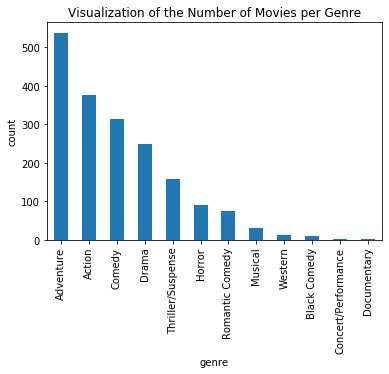

In [36]:
#Using our bar_graph_count function to visualize the movies_genre group 
#It takes the following inputs: df, x_column, y_column, title
movies_genre.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_genre, "genre", "count", "Visualization of the Number of Movies per Genre")

In [37]:
#Creating a data frame of the movies creative_type count 
movies_ct = groupby_count(movies, "creative_type", "creative_type") 
movies_ct["creative_type"]

0    Contemporary Fiction
1           Dramatization
2                 Factual
3                 Fantasy
4      Historical Fiction
5            Kids Fiction
6         Science Fiction
7              Super Hero
Name: creative_type, dtype: category
Categories (8, object): [Contemporary Fiction, Dramatization, Factual, Fantasy, Historical Fiction, Kids Fiction, Science Fiction, Super Hero]

Text(0.5, 0, 'creative_type')

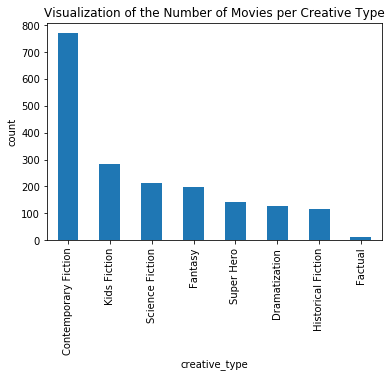

In [38]:
#Sorting the df, so the bar graph will be in descending order
movies_ct.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_ct, "creative_type", "count", "Visualization of the Number of Movies per Creative Type")


In [39]:
movies_year = groupby_count(movies, "year", "genre")
movies_year

,count,year
0,26,2000
1,90,2001
2,91,2002
3,100,2003
4,101,2004
5,83,2005
6,107,2006
7,86,2007
8,98,2008
9,98,2009


Text(0.5, 0, 'year')

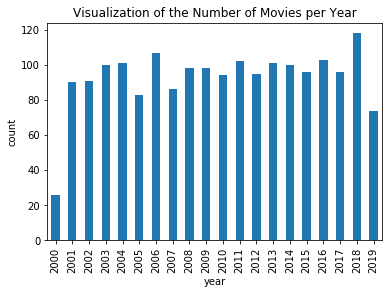

In [40]:
bar_graph_count(movies_year, "year", "count", "Visualization of the Number of Movies per Year")


In [41]:
movies_month = groupby_count(movies, "month", "genre")
movies_month

,count,month
0,71,1
1,121,2
2,158,3
3,94,4
4,190,5
5,225,6
6,215,7
7,137,8
8,85,9
9,108,10


Text(0.5, 0, 'month')

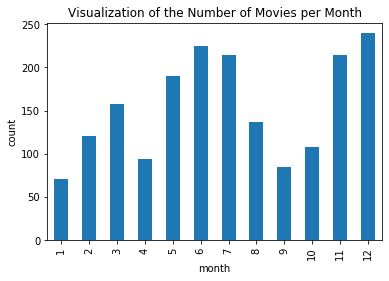

In [42]:
bar_graph_count(movies_month, "month", "count", "Visualization of the Number of Movies per Month")

In [43]:
movies_source = groupby_count(movies, "source", "genre")
movies_source

,count,source
0,176,Based on Comic/Graphic Novel
1,72,Based on Factual Book/Article
2,387,Based on Fiction Book/Short Story
3,24,Based on Folk Tale/Legend/Fairytale
4,15,Based on Game
5,3,Based on Movie
6,4,Based on Musical or Opera
7,10,Based on Play
8,77,Based on Real Life Events
9,3,Based on Religious Text


Text(0.5, 0, 'source')

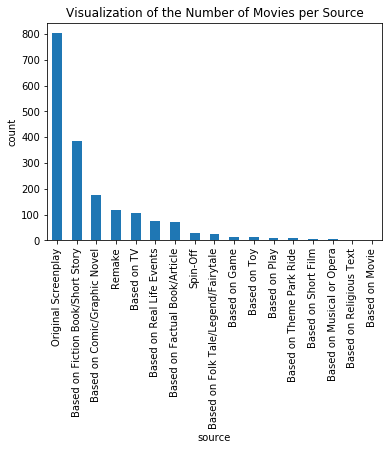

In [44]:
movies_source.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_source, "source", "count", "Visualization of the Number of Movies per Source")

In [45]:
movies_distributor = groupby_count(movies, "distributor", "genre")
movies_distributor

,count,distributor
0,249,20th Century Fox
1,36,Dreamworks SKG
2,2,FilmDistrict
3,9,Focus Features
4,12,Fox Searchlight
5,69,Lionsgate
6,17,MGM
7,20,Miramax
8,14,Miramax/Dimension
9,39,New Line


In [46]:
movies_distributor = movies_distributor[movies_distributor["count"] > 0]
movies_distributor

,count,distributor
0,249,20th Century Fox
1,36,Dreamworks SKG
2,2,FilmDistrict
3,9,Focus Features
4,12,Fox Searchlight
5,69,Lionsgate
6,17,MGM
7,20,Miramax
8,14,Miramax/Dimension
9,39,New Line


Text(0.5, 0, 'distributor')

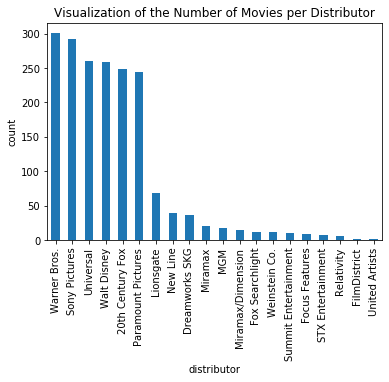

In [47]:
movies_distributor.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_distributor, "distributor", "count", "Visualization of the Number of Movies per Distributor")

In [48]:
movies_production_method = groupby_count(movies, "production_method", "genre")
movies_production_method

,count,production_method
0,176,Animation/Live Action
1,216,Digital Animation
2,14,Hand Animation
3,1451,Live Action
4,2,Stop-Motion Animation


Text(0.5, 0, 'production_method')

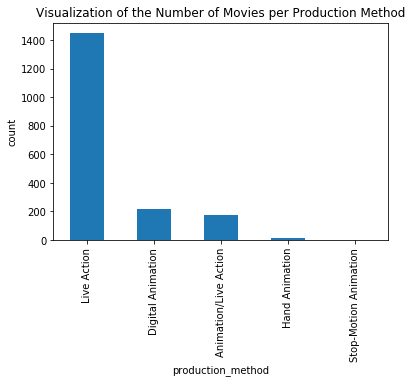

In [49]:
movies_production_method.sort_values(['count'], ascending=[False], inplace = True)
bar_graph_count(movies_production_method, "production_method", "count", "Visualization of the Number of Movies per Production Method")

In [50]:
#Discretizing the df 
movies_discretized = movies.copy()

In [51]:
#Getting a list of all of our columns 
movies_discretized.columns

Index(['creative_type', 'domestic_box_office', 'genre',
       'inflated_adj_dom_box_office', 'int_box_office', 'max_theaters',
       'open_wkend_rev', 'open_wkend_theaters', 'budget', 'production_method',
       'released', 'released_ww', 'year', 'year_ww', 'source', 'distributor',
       'engagements', 'title', 'world_wide_box_office', 'month', 'day',
       'month_ww', 'day_ww', 'dom_profit', 'int_profit', 'ww_profit',
       'dom_percent_profit', 'int_percent_profit', 'ww_percent_profit',
       'dom_cumulative_mean_creative_type', 'dom_exp_mean_creative_type',
       'int_cumulative_mean_creative_type', 'int_exp_mean_creative_type',
       'ww_cumulative_mean_creative_type', 'ww_exp_mean_creative_type',
       'dom_cumulative_mean_genre', 'dom_exp_mean_genre',
       'int_cumulative_mean_genre', 'int_exp_mean_genre',
       'ww_cumulative_mean_genre', 'ww_exp_mean_genre',
       'dom_cumulative_mean_production_method',
       'dom_exp_mean_production_method',
       'int_cumulati

In [52]:
# We are going to descritize our data based on the quartiles. The categories are: 
# extremely_low, low, high, extremely_high
# We are using our quartile_discretize function that takes the following arguments: 
#(df, column, category)
categories = ["extremely_low", "low", "high", "extremely_high"]
movies_discretized["domestic_box_office"] = quartile_discretize(movies_discretized, "domestic_box_office", categories)
movies_discretized["inflated_adj_dom_box_office"] = quartile_discretize(movies_discretized, "inflated_adj_dom_box_office", categories)
movies_discretized["int_box_office"] = quartile_discretize(movies_discretized, "int_box_office", categories)
movies_discretized["max_theaters"] = quartile_discretize(movies_discretized, "max_theaters", categories)
movies_discretized["open_wkend_rev"] = quartile_discretize(movies_discretized, "open_wkend_rev", categories)
movies_discretized["open_wkend_theaters"] = quartile_discretize(movies_discretized, "open_wkend_theaters", categories)
movies_discretized["budget"] = quartile_discretize(movies_discretized, "budget", categories)
movies_discretized["engagements"] = quartile_discretize(movies_discretized, "engagements", categories)
movies_discretized["world_wide_box_office"] = quartile_discretize(movies_discretized, "world_wide_box_office", categories)

In [53]:
movies_discretized.columns

Index(['creative_type', 'domestic_box_office', 'genre',
       'inflated_adj_dom_box_office', 'int_box_office', 'max_theaters',
       'open_wkend_rev', 'open_wkend_theaters', 'budget', 'production_method',
       'released', 'released_ww', 'year', 'year_ww', 'source', 'distributor',
       'engagements', 'title', 'world_wide_box_office', 'month', 'day',
       'month_ww', 'day_ww', 'dom_profit', 'int_profit', 'ww_profit',
       'dom_percent_profit', 'int_percent_profit', 'ww_percent_profit',
       'dom_cumulative_mean_creative_type', 'dom_exp_mean_creative_type',
       'int_cumulative_mean_creative_type', 'int_exp_mean_creative_type',
       'ww_cumulative_mean_creative_type', 'ww_exp_mean_creative_type',
       'dom_cumulative_mean_genre', 'dom_exp_mean_genre',
       'int_cumulative_mean_genre', 'int_exp_mean_genre',
       'ww_cumulative_mean_genre', 'ww_exp_mean_genre',
       'dom_cumulative_mean_production_method',
       'dom_exp_mean_production_method',
       'int_cumulati

In [54]:
#The other columns that are going to be discretized contain information regarding percent profit... We have decided to 
# use the following categories for percent profit 
#We are creating new label categories ; Discretized Percent Profit 
#We cannot use our function on this, because we are not discretizing by quartiles
categories = ["negative", "low", "high", "extremely_high"]

movies_discretized["dom_percent_profit"] = pd.cut(movies_discretized["dom_percent_profit"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_percent_profit"] = pd.cut(movies_discretized["int_percent_profit"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_percent_profit"] = pd.cut(movies_discretized["ww_percent_profit"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_cumulative_mean_creative_type"] = pd.cut(movies_discretized["dom_cumulative_mean_creative_type"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_exp_mean_creative_type"] = pd.cut(movies_discretized["dom_exp_mean_creative_type"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_cumulative_mean_creative_type"] = pd.cut(movies_discretized["int_cumulative_mean_creative_type"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_exp_mean_creative_type"] = pd.cut(movies_discretized["int_exp_mean_creative_type"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_cumulative_mean_creative_type"] = pd.cut(movies_discretized["ww_cumulative_mean_creative_type"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_exp_mean_creative_type"] = pd.cut(movies_discretized["ww_exp_mean_creative_type"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_cumulative_mean_genre"] = pd.cut(movies_discretized["dom_cumulative_mean_genre"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_exp_mean_genre"] = pd.cut(movies_discretized["dom_exp_mean_genre"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_cumulative_mean_genre"] = pd.cut(movies_discretized["int_cumulative_mean_genre"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_exp_mean_genre"] = pd.cut(movies_discretized["int_exp_mean_genre"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_cumulative_mean_genre"] = pd.cut(movies_discretized["ww_cumulative_mean_genre"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_exp_mean_genre"] = pd.cut(movies_discretized["ww_exp_mean_genre"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_cumulative_mean_production_method"] = pd.cut(movies_discretized["dom_cumulative_mean_production_method"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_exp_mean_production_method"] = pd.cut(movies_discretized["dom_exp_mean_production_method"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_cumulative_mean_production_method"] = pd.cut(movies_discretized["int_cumulative_mean_production_method"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_exp_mean_production_method"] = pd.cut(movies_discretized["int_exp_mean_production_method"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_cumulative_mean_production_method"] = pd.cut(movies_discretized["ww_cumulative_mean_production_method"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_exp_mean_production_method"] = pd.cut(movies_discretized["ww_exp_mean_production_method"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_cumulative_mean_source"] = pd.cut(movies_discretized["dom_cumulative_mean_source"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_exp_mean_source"] = pd.cut(movies_discretized["dom_exp_mean_source"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_cumulative_mean_source"] = pd.cut(movies_discretized["int_cumulative_mean_source"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_exp_mean_source"] = pd.cut(movies_discretized["int_exp_mean_source"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_cumulative_mean_source"] = pd.cut(movies_discretized["ww_cumulative_mean_source"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_exp_mean_source"] = pd.cut(movies_discretized["ww_exp_mean_source"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_cumulative_mean_distributor"] = pd.cut(movies_discretized["dom_cumulative_mean_distributor"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_exp_mean_distributor"] = pd.cut(movies_discretized["dom_exp_mean_distributor"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_cumulative_mean_distributor"] = pd.cut(movies_discretized["int_cumulative_mean_distributor"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_exp_mean_distributor"] = pd.cut(movies_discretized["int_exp_mean_distributor"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_cumulative_mean_distributor"] = pd.cut(movies_discretized["ww_cumulative_mean_distributor"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_exp_mean_distributor"] = pd.cut(movies_discretized["ww_exp_mean_distributor"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_cumulative_mean_month"] = pd.cut(movies_discretized["dom_cumulative_mean_month"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["dom_exp_mean_month"] = pd.cut(movies_discretized["dom_exp_mean_month"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_cumulative_mean_month"] = pd.cut(movies_discretized["int_cumulative_mean_month"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["int_exp_mean_month"] = pd.cut(movies_discretized["int_exp_mean_month"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_cumulative_mean_month"] = pd.cut(movies_discretized["ww_cumulative_mean_month"], [-100, 0, 50, 150, 999999], labels = categories)
movies_discretized["ww_exp_mean_month"] = pd.cut(movies_discretized["ww_exp_mean_month"], [-100, 0, 50, 150, 999999], labels = categories)

In [55]:
movies_discretized.dom_profit.describe()

count    1.859000e+03
mean     5.330808e+07
std      8.312150e+07
min     -2.841540e+08
25%      9.498052e+06
50%      4.270688e+07
75%      7.955942e+07
max      6.306622e+08
Name: dom_profit, dtype: float64

In [56]:
#negative = -999999999 - 0 
#low = 0 - 40000000
# high = 40000000 - 79559420
# extremely_high = 79559420 - 9999999999
movies_discretized["dom_profit"] = pd.cut(movies_discretized["dom_profit"], [-999999999, 0, 40000000, 79559420, 999999999], labels = categories)

In [57]:
movies_discretized.int_profit.describe()

count    1.859000e+03
mean     1.074237e+08
std      1.714774e+08
min     -1.694891e+08
25%      3.747336e+06
50%      4.991367e+07
75%      1.488067e+08
max      1.604198e+09
Name: int_profit, dtype: float64

In [58]:
#negative = -999999999 - 0 
#low = 0 - 3747336
# high = 3747336 - 49913670
# extremely_high = 49913670 - 9999999999
movies_discretized["int_profit"] = pd.cut(movies_discretized["int_profit"], [-999999999, 0, 3747336, 49913670, 9999999999], labels = categories)

In [59]:
movies_discretized.ww_profit.describe()

count    1.859000e+03
mean     2.477746e+08
std      2.614642e+08
min     -1.036431e+08
25%      8.632919e+07
50%      1.561279e+08
75%      3.031389e+08
max      2.395446e+09
Name: ww_profit, dtype: float64

In [60]:
#negative = -999999999 - 0 
#low = 0 - 10000000
# high = 10000000 - 303138900
# extremely_high = 303138900 - 9999999999
movies_discretized["ww_profit"] = pd.cut(movies_discretized["ww_profit"], [-999999999, 0, 10000000, 303138900, 9999999999], labels = categories)

In [61]:
#We are setting new categories for the day column by creating a new column for week 
# week_1 is the first 7 days of the month, week_2 is days 8 - 14, week_3 is days 15 - 21, and week_4 are the 
# rest of the days
categories = ["week_1", "week_2", "week_3", "week_4"]

movies_discretized["week"] = pd.cut(movies_discretized["day"], [0, 8, 15, 22, 32], labels = categories)

In [62]:
#Looking at the relationship between genre and percent profit 
movies_discretized_genre_pp = groupby_2_count(movies_discretized, "genre", "dom_percent_profit", "genre")
movies_discretized_genre_pp

,count,genre,dom_percent_profit
0,125,Action,negative
1,106,Action,low
2,110,Action,high
3,36,Action,extremely_high
4,160,Adventure,negative
5,151,Adventure,low
6,130,Adventure,high
7,97,Adventure,extremely_high
8,2,Black Comedy,negative
9,2,Black Comedy,low


In [63]:
#Now we are getting the sum of each genre category... We do not have a function for sum... we could go back and rework 
#our function.
movies_discretized_genre_pp.groupby("genre")["count"].sum()

genre
Action                 377
Adventure              538
Black Comedy             9
Comedy                 315
Concert/Performance      2
Documentary              2
Drama                  249
Horror                  91
Musical                 30
Romantic Comedy         76
Thriller/Suspense      158
Western                 12
Name: count, dtype: int64

In [64]:
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre"]

In [65]:
# We ultimately want a column that contains the total counts for each genre group. We are probably doing this in 
# a roundabout way, but as I am extremely new to python this is the best way I can think of doing it. We are going to create 
# a new column that replicates the genre column called genre_count and then we will use the replace function to 
# replace the genre names with their total count 
#First, replicating the income level column in a column named budget_category_count
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre"] 
#Now replacing the income level with the total count for each income level 
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Action"], 377 )
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Adventure"], 538)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Black Comedy"], 9)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Comedy"], 315)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Concert/Performance"], 2)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Documentary"], 2)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Drama"], 249)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Horror"], 91)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Musical"], 30)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Romantic Comedy"], 76)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Thriller/Suspense"], 158)
movies_discretized_genre_pp["genre_count"] = movies_discretized_genre_pp["genre_count"].replace(["Western"], 12)

In [66]:
movies_discretized_genre_pp.head()

,count,genre,dom_percent_profit,genre_count
0,125,Action,negative,377
1,106,Action,low,377
2,110,Action,high,377
3,36,Action,extremely_high,377
4,160,Adventure,negative,538


In [67]:
movies_discretized_genre_pp["genre_count"] = pd.to_numeric(movies_discretized_genre_pp["genre_count"])

In [68]:
#Okay, we are one step closer... Now, we need to create a column that takes the counts/genre_counts * 100 
movies_discretized_genre_pp["percent"] = movies_discretized_genre_pp["count"]/movies_discretized_genre_pp["genre_count"] *100

In [69]:
movies_discretized_genre_pp.head()

,count,genre,dom_percent_profit,genre_count,percent
0,125,Action,negative,377,33.156499
1,106,Action,low,377,28.116711
2,110,Action,high,377,29.177719
3,36,Action,extremely_high,377,9.549072
4,160,Adventure,negative,538,29.739777


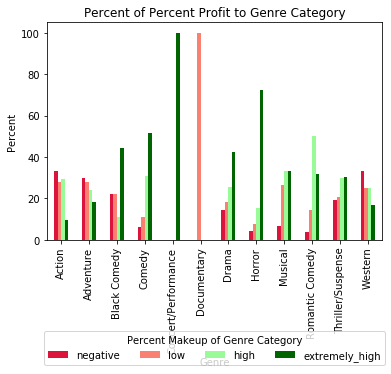

In [70]:
'''Attempting to graph this data using a grouped bar chart: 
formula: df.pivot(columns, group, values).plot(kind = "type of graph", color = ["color to use, can be a list of colors"], 
title = "you can set the title of your graph here")'''
graph = movies_discretized_genre_pp.pivot("genre", "dom_percent_profit", 
                                                "percent").plot(kind="bar", color = ["crimson", "salmon", "palegreen", "darkgreen"],
                                                               title = "Percent of Percent Profit to Genre Category")
#Changing the y label of our graph to Percent
plt.ylabel("Percent")
#Changing the x axis label of our graph to Budget Category 
plt.xlabel("Genre")
#How to change the tick labels (we ended up not needing this, but want to keep for future reference)
#plt.Axes.set_xticklabels(graph, labels = ['extremely low', 'low', 'high', 'extremely high'])
#moving the legend position to underneath the graph, also setting it to have 4 columns so the legend is in a 
#straight single line and adding a legend title
plt.legend( loc = "lower center", bbox_to_anchor = (.5, -.6), ncol = 4, title = "Percent Makeup of Genre Category")
